# Section 1: Running Causal Forests on GSS data

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import deepcopy

from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.model_selection import train_test_split
from econml.dml import CausalForestDML
import shap

import warnings
warnings.filterwarnings("ignore")

def fullDisplay():
    pd.set_option("display.max_rows", None, "display.max_columns", None)

def defaultDisplay():
    pd.reset_option('^display.', silent=True)

## Loading and Cleaning data

In [3]:
# w = 0 means the question had "assistance", w = 1 means the question had "welfare"
# y = 0 means the responder said no, y = 1 means yes
welfare_raw = pd.read_csv("Data/welfarelabel.csv", low_memory=False)
labels = welfare_raw['y'].values
treatments = welfare_raw['w']
treatments = treatments.replace({0:1, 1:0}) # we want 1 to be assistance, and 0 to be welfare, so if the TE is positive then it means people responded favorably to assistance
welfare_raw

,year,id,wrkstat,hrs1,hrs2,evwork,occ,prestige,wrkslf,wrkgovt,...,adults_miss,unrelat_miss,earnrs_miss,income_miss,rincome_miss,income86_miss,partyid_miss,polviews_miss,attblack,attblack_miss
0,1986,1,working fulltime,40.000000,38.613701,1.1395408,270.00000,44.000000,someone else,private,...,0,0,0,0,0,0,0,0,0.666667,0
1,1986,2,keeping house,41.733318,38.613701,1,195.00000,51.000000,someone else,private,...,0,1,0,0,1,0,0,0,0.500000,0
2,1986,3,working fulltime,40.000000,38.613701,1.1395408,184.00000,51.000000,someone else,private,...,0,1,0,0,0,0,0,0,0.250000,0
3,1986,4,retired,41.733318,38.613701,1,311.00000,36.000000,someone else,1,...,0,0,0,0,1,0,0,0,0.500000,0
4,1986,5,working parttime,41.733318,38.613701,1.1395408,449.41599,40.335918,someone else,1.8203658,...,0,0,0,0,0,0,0,0,0.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36496,2010,2040,retired,41.733318,38.613701,1,449.41599,40.335918,someone else,private,...,0,0,0,0,1,1,0,0,0.500000,0
36497,2010,2041,retired,41.733318,38.613701,1,449.41599,40.335918,someone else,private,...,0,0,0,0,1,1,0,0,0.750000,0
36498,2010,2042,working fulltime,40.000000,38.613701,1.1395408,449.41599,40.335918,someone else,private,...,0,1,0,0,0,1,0,0,0.500000,0
36499,2010,2043,working fulltime,49.000000,38.613701,1.1395408,449.41599,40.335918,someone else,private,...,0,1,0,0,1,1,0,0,0.615292,1


In [8]:
def cleanWelfare(welfare_raw):
    welfare = welfare_raw.copy()

    toClean = set(['commute', 'childs', 'age', 'preteen', 'adults', 'unrelat', 'earnrs'])
    toEncode = set(['year', 'occ'])

    encoders = {} # want a dictionary to keep track of columns and their encoded values so can decode when done

    for column in welfare:
        if '_' not in column:
            if column in toEncode:
                le = LabelEncoder()
                le.fit(welfare[column])
                welfare[column] = le.transform(welfare[column])
                encoders[column] = le 
            elif column in toClean:
                if column == 'commute':
                    welfare[column] = pd.to_numeric(welfare[column].apply(lambda x: 97 if x == '97+ minutes' else x), errors='coerce')
                elif column == 'childs' or column == 'earnrs':
                    welfare[column] = pd.to_numeric(welfare[column].apply(lambda x: 8 if x == 'eight or more' else x), errors='coerce')
                elif column == 'age':
                    welfare[column] = pd.to_numeric(welfare[column].apply(lambda x: 89 if x == '89 or older' else x), errors='coerce')
                elif column == 'preteen' or column == 'adults' or column =='unrelat':
                    welfare[column] = pd.to_numeric(welfare[column].apply(lambda x: 8 if x == '8 or more' else x), errors='coerce')
                else:
                    continue # should never reach here
                welfare[column] = normalize(welfare[column].values.reshape(1, -1))[0] # once column converted to float, normalize
            else:
                if welfare[column].dtype == welfare['teens'].dtype: # float64 column
                    welfare[column] = normalize(welfare[column].values.reshape(1, -1))[0]
                elif welfare[column].dtype == welfare['polviews'].dtype: # object column
                    le = LabelEncoder()
                    le.fit(welfare[column])
                    welfare[column] = le.transform(welfare[column])
                    encoders[column] = le 
                else:
                    continue # should never reach here
    return welfare, encoders


welfare, encoders = cleanWelfare(welfare_raw.drop(columns=['_merge', 'y', 'w']))
welfare

,year,id,wrkstat,hrs1,hrs2,evwork,occ,prestige,wrkslf,wrkgovt,...,adults_miss,unrelat_miss,earnrs_miss,income_miss,rincome_miss,income86_miss,partyid_miss,polviews_miss,attblack,attblack_miss
0,0,1,7,0.004845,0.005228,1,135,0.005641,2,2,...,0,0,0,0,0,0,0,0,0.005440,0
1,0,2,1,0.005055,0.005228,0,106,0.006538,2,2,...,0,1,0,0,1,0,0,0,0.004080,0
2,0,3,7,0.004845,0.005228,1,99,0.006538,2,2,...,0,1,0,0,0,0,0,0,0.002040,0
3,0,4,3,0.005055,0.005228,0,142,0.004615,2,0,...,0,0,0,0,1,0,0,0,0.004080,0
4,0,5,8,0.005055,0.005228,1,211,0.005171,2,1,...,0,0,0,0,0,0,0,0,0.004080,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36496,15,2040,3,0.005055,0.005228,0,211,0.005171,2,2,...,0,0,0,0,1,1,0,0,0.004080,0
36497,15,2041,3,0.005055,0.005228,0,211,0.005171,2,2,...,0,0,0,0,1,1,0,0,0.006120,0
36498,15,2042,7,0.004845,0.005228,1,211,0.005171,2,2,...,0,1,0,0,0,1,0,0,0.004080,0
36499,15,2043,7,0.005935,0.005228,1,211,0.005171,2,2,...,0,1,0,0,1,1,0,0,0.005021,1


## Estimating ATE and its CI

In [4]:
def estimate_cf(y, X, treatments, test_size=0.2, criterion='mse', cv=5):
    # split data into train and test sets 
    X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X, y, treatments, test_size=test_size)
        
    # specify hyperparams of model
    est = CausalForestDML(criterion='het', 
                            n_estimators=1000,       
                            max_samples=0.5,
                            discrete_treatment=True,
                            honest=True,
                            inference=True,
                            cv=cv,
                            )
    # fit model
    est.fit(Y_train, T_train, X=X_train, W=None)
        
    return est, X_test

In [5]:
est_general, X_test_general = estimate_cf(labels, welfare, treatments)
est_general.ate_inference(X_test_general)

In [6]:
general_lb, general_ub = est_general.ate_interval(X_test_general, alpha=0.05)

print("The test ATE is equal to:", est_general.ate(X_test_general))
print("With a 95% confidence interval of (" + str(general_lb) + ", " + str(general_ub) + ")")

The test ATE is equal to: 0.33150221980845607
With a 95% confidence interval of (0.25141712084282897, 0.41158731877408317)


## CATES

### CATES for Party Identification

In [34]:
# view all partyid types
welfare_raw['partyid'].value_counts()

not str democrat      7093
not str republican    5969
independent           5859
strong democrat       5666
ind,near dem          4110
strong republican     3880
ind,near rep          3196
other party            512
2.8216343              216
Name: partyid, dtype: int64

In [35]:
# view the corresponding numerical encodings for the cleaned data
welfare['partyid'].value_counts()

4    7093
5    5969
3    5859
7    5666
1    4110
8    3880
2    3196
6     512
0     216
Name: partyid, dtype: int64

In [36]:
notStrongDem = welfare.loc[welfare['partyid'] == 4]
notStrongDem_CATE = est_general.ate(notStrongDem)
notStrongDem_lb, notStrongDem_ub = est_general.ate_interval(notStrongDem, alpha=0.05)

notStrongRep = welfare.loc[welfare['partyid'] == 5]
notStrongRep_CATE = est_general.ate(notStrongRep)
notStrongRep_lb, notStrongRep_ub = est_general.ate_interval(notStrongRep, alpha=0.05)

strongDem = welfare.loc[welfare['partyid'] == 7]
strongDem_CATE = est_general.ate(strongDem)
strongDem_lb, strongDem_ub = est_general.ate_interval(strongDem, alpha=0.05)

strongRep = welfare.loc[welfare['partyid'] == 8]
strongRep_CATE = est_general.ate(strongRep)
strongRep_lb, strongRep_ub = est_general.ate_interval(strongRep, alpha=0.05)

nearDem = welfare.loc[welfare['partyid'] == 1]
nearDem_CATE = est_general.ate(nearDem)
nearDem_lb, nearDem_ub = est_general.ate_interval(nearDem, alpha=0.05)

nearRep = welfare.loc[welfare['partyid'] == 2]
nearRep_CATE = est_general.ate(nearRep)
nearRep_lb, nearRep_ub = est_general.ate_interval(nearRep, alpha=0.05)

independent = welfare.loc[welfare['partyid'] == 3]
independent_CATE = est_general.ate(independent)
independent_lb, independent_ub = est_general.ate_interval(independent, alpha=0.05)

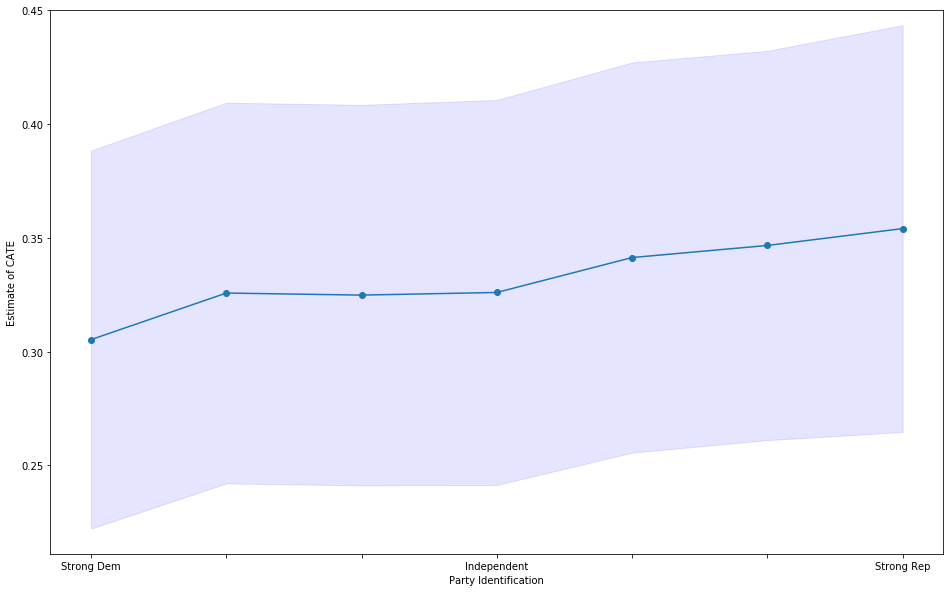

In [37]:
partyid_xs = ['Strong Dem', 'Weak Dem', 'Dem Lean', 'Ind', 'Rep Lean', 'Weak Rep', 'Rep']
partyid_ys = [strongDem_CATE, notStrongDem_CATE, nearDem_CATE, independent_CATE, nearRep_CATE, notStrongRep_CATE, strongRep_CATE]
partyid_lbs = [strongDem_lb, notStrongDem_lb, nearDem_lb, independent_lb, nearRep_lb, notStrongRep_lb, strongRep_lb]
partyid_ubs = [strongDem_ub, notStrongDem_ub, nearDem_ub, independent_ub, nearRep_ub, notStrongRep_ub, strongRep_ub]

plt.figure(figsize=(16,10))
plt.xlabel("Party Identification")
plt.ylabel("Estimate of CATE")
plt.plot(partyid_xs, partyid_ys, marker='o')
plt.fill_between(partyid_xs, partyid_lbs, partyid_ubs, color='b', alpha=.1)
plt.xticks(np.arange(7), ["Strong Dem", "", "", "Independent", "", "", "Strong Rep"])
plt.ylim(top=0.45)
plt.show()

### CATES for Political Views

In [11]:
# view all polviews types
welfare_raw['polviews'].value_counts()

moderate                12257
slghtly conservative     5053
conservative             5016
4.1220088                4405
slightly liberal         4008
liberal                  3777
extrmly conservative     1058
extremely liberal         927
Name: polviews, dtype: int64

In [12]:
# view the corresponding numerical encodings for the cleaned data
welfare['polviews'].value_counts()

5    12257
6     5053
1     5016
0     4405
7     4008
4     3777
3     1058
2      927
Name: polviews, dtype: int64

In [38]:
extremeLib = welfare.loc[welfare['polviews'] == 2]
extremeLib_CATE = est_general.ate(extremeLib)
extremeLib_lb, extremeLib_ub = est_general.ate_interval(extremeLib, alpha=0.05)

extremeCon = welfare.loc[welfare['polviews'] == 3]
extremeCon_CATE = est_general.ate(extremeCon)
extremeCon_lb, extremeCon_ub = est_general.ate_interval(extremeCon, alpha=0.05)

liberal = welfare.loc[welfare['polviews'] == 4]
liberal_CATE = est_general.ate(liberal)
liberal_lb, liberal_ub = est_general.ate_interval(liberal, alpha=0.05)

conservative = welfare.loc[welfare['polviews'] == 1]
conservative_CATE = est_general.ate(conservative)
conservative_lb, conservative_ub = est_general.ate_interval(conservative, alpha=0.05)

slightLib = welfare.loc[welfare['polviews'] == 7]
slightLib_CATE = est_general.ate(slightLib)
slightLib_lb, slightLib_ub = est_general.ate_interval(slightLib, alpha=0.05)

slightCon = welfare.loc[welfare['polviews'] == 6]
slightCon_CATE = est_general.ate(slightCon)
slightCon_lb, slightCon_ub = est_general.ate_interval(slightCon, alpha=0.05)

moderate = welfare.loc[welfare['polviews'] == 5]
moderate_CATE = est_general.ate(moderate)
moderate_lb, moderate_ub = est_general.ate_interval(moderate, alpha=0.05)

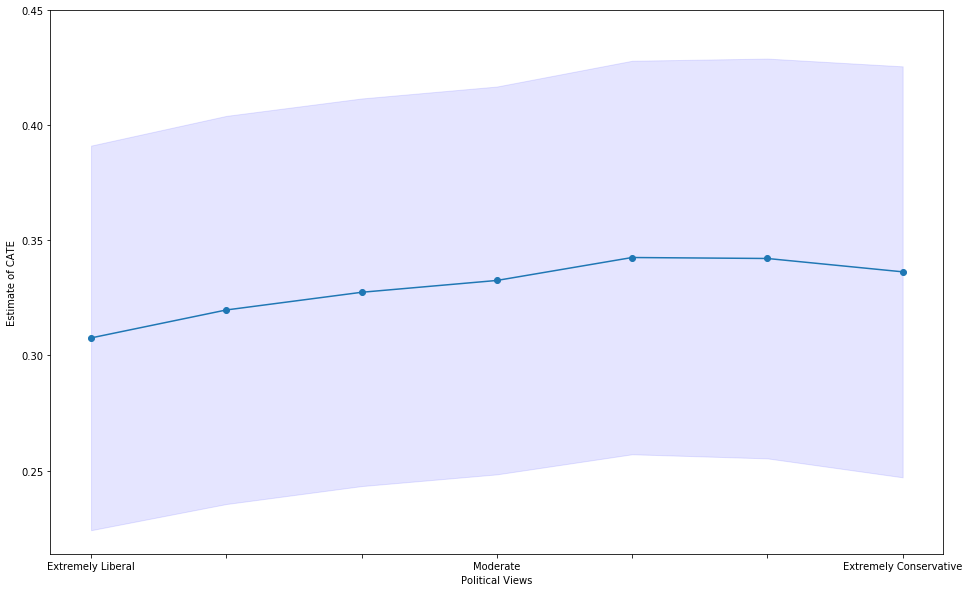

In [39]:
polview_xs = ['Extremely lib', 'Lib', 'Slight lib', 'Moderate', 'Slight con', 'Con', 'Extremely con']
polview_ys = [extremeLib_CATE, liberal_CATE, slightLib_CATE, moderate_CATE, slightCon_CATE, conservative_CATE, extremeCon_CATE]
polview_lbs = [extremeLib_lb, liberal_lb, slightLib_lb, moderate_lb, slightCon_lb, conservative_lb, extremeCon_lb]
polview_ubs = [extremeLib_ub, liberal_ub, slightLib_ub, moderate_ub, slightCon_ub, conservative_ub, extremeCon_ub]

plt.figure(figsize=(16,10))
plt.xlabel("Political Views")
plt.ylabel("Estimate of CATE")
plt.plot(polview_xs, polview_ys, marker='o')
plt.fill_between(polview_xs, polview_lbs, polview_ubs, color='b', alpha=.1)
plt.xticks(np.arange(7), ["Extremely Liberal", "", "", "Moderate", "", "", "Extremely Conservative"])
plt.ylim(top=0.45)
plt.show()

### CATES for Age

In [23]:
welfare['age_raw'] = welfare_raw['age']

ages = list(np.unique(welfare['age_raw']))
ages.sort()
ages.remove('46.091595')
ageGroups = []

for age in ages:
    ageGroups.append(welfare.loc[welfare['age_raw'] == age].drop(columns=['age_raw']))

age_CATES = []
age_lbs = []
age_ubs = []

for group in ageGroups:
    age_CATES.append(est_general.ate(group))
    age_lb, age_ub = est_general.ate_interval(group, alpha=0.05)
    age_lbs.append(age_lb)
    age_ubs.append(age_ub)

welfare.drop(columns=['age_raw'], inplace=True)

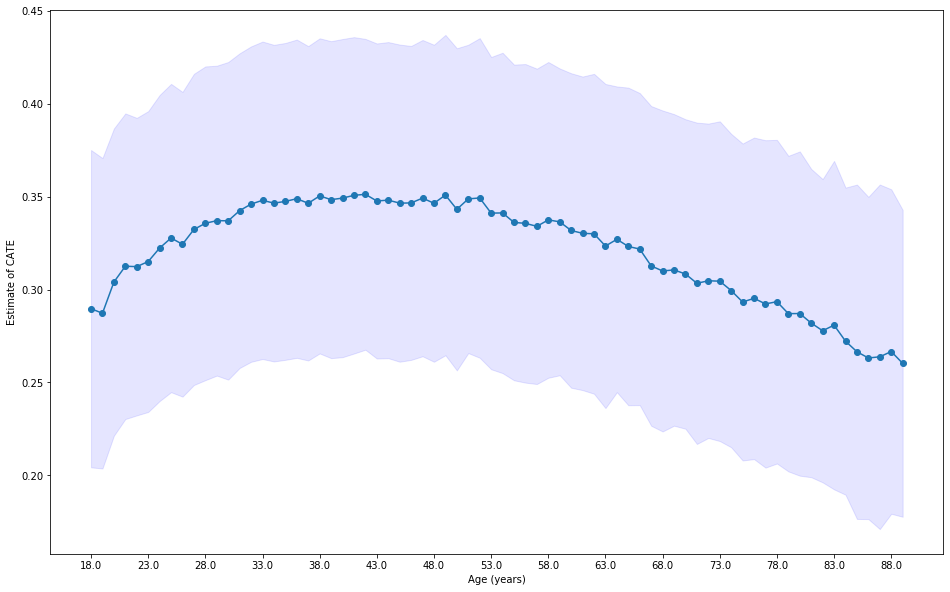

In [24]:
ages[-1] = '89'
age_xs = list(map(lambda x: float(x), ages))
plt.figure(figsize=(16,10))
plt.xlabel("Age (years)")
plt.ylabel("Estimate of CATE")
plt.plot(age_xs, age_CATES, marker='o')
plt.fill_between(age_xs, age_lbs, age_ubs, color='b', alpha=.1)
plt.xticks(np.linspace(start=18, stop=88, num=15), np.linspace(start=18, stop=88, num=15))
plt.show()

### CATES for Education

In [73]:
welfare['educ_raw'] = welfare_raw['educ']

educs = list(np.unique(welfare['educ_raw']))
educs.sort()
del educs[14]
educGroups = []

for educ in educs:
    educGroups.append(welfare.loc[welfare['educ_raw'] == educ].drop(columns=['educ_raw']))

educ_CATES = []
educ_lbs = []
educ_ubs = []

for group in educGroups:
    educ_CATES.append(est_general.ate(group))
    educ_lb, educ_ub = est_general.ate_interval(group, alpha=0.05)
    educ_lbs.append(educ_lb)
    educ_ubs.append(educ_ub)

welfare.drop(columns=['educ_raw'], inplace=True)

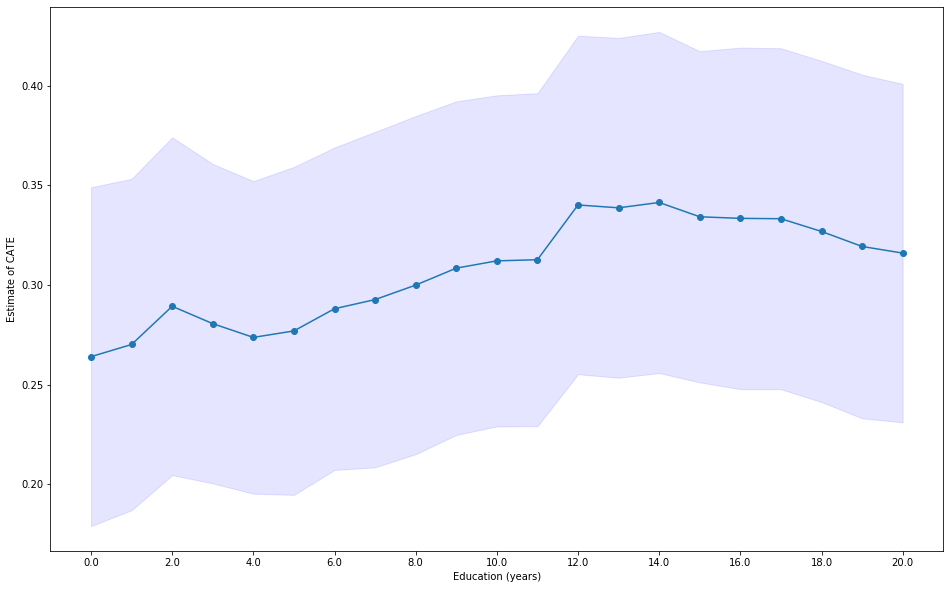

In [74]:
plt.figure(figsize=(16,10))
plt.xlabel("Education (years)")
plt.ylabel("Estimate of CATE")
plt.plot(educs, educ_CATES, marker='o')
plt.fill_between(educs, educ_lbs, educ_ubs, color='b', alpha=.1)
plt.xticks(np.linspace(start=0, stop=20, num=11), np.linspace(start=0, stop=20, num=11))
plt.show()

### CATES for Negative attitudes toward blacks

In [81]:
welfare['attblack_raw'] = welfare_raw['attblack']

attblacks = list(np.unique(welfare['attblack_raw']))
attblacks.sort()
del attblacks[4]
attblackGroups = []

for attblack in attblacks:
    attblackGroups.append(welfare.loc[welfare['attblack_raw'] == attblack].drop(columns=['attblack_raw']))

attblack_CATES = []
attblack_lbs = []
attblack_ubs = []

for group in attblackGroups:
    attblack_CATES.append(est_general.ate(group))
    attblack_lb, attblack_ub = est_general.ate_interval(group, alpha=0.05)
    attblack_lbs.append(attblack_lb)
    attblack_ubs.append(attblack_ub)

welfare.drop(columns=['attblack_raw'], inplace=True)

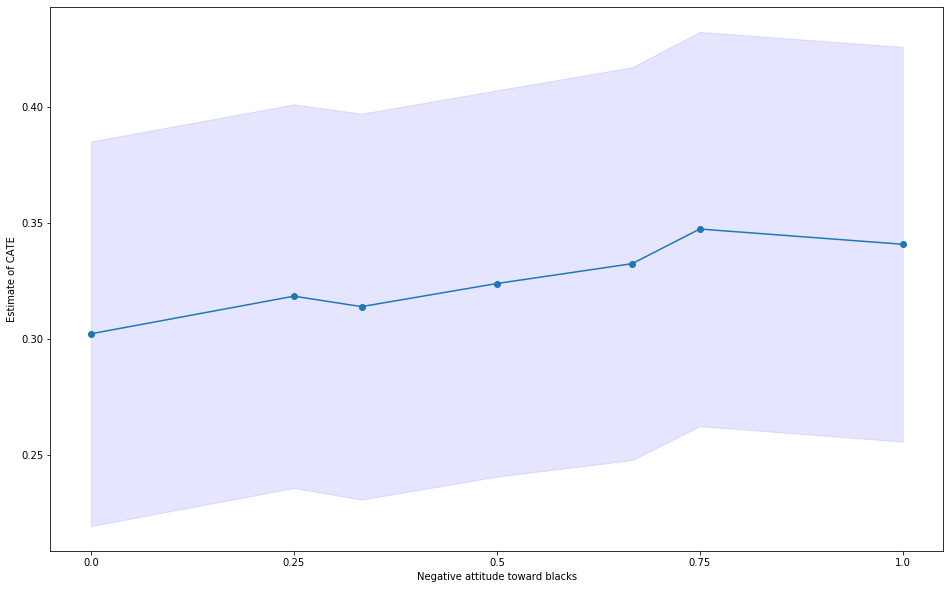

In [83]:
plt.figure(figsize=(16,10))
plt.xlabel("Negative attitude toward blacks")
plt.ylabel("Estimate of CATE")
plt.plot(attblacks, attblack_CATES, marker='o')
plt.fill_between(attblacks, attblack_lbs, attblack_ubs, color='b', alpha=.1)
plt.xticks(np.linspace(start=0, stop=1, num=5), np.linspace(start=0, stop=1, num=5))
plt.show()

### CATES for Years

In [86]:
welfare['year_raw'] = welfare_raw['year']

years = list(np.unique(welfare['year_raw']))
years.sort()
yearGroups = []

for year in years:
    yearGroups.append(welfare.loc[welfare['year_raw'] == year].drop(columns=['year_raw']))

year_CATES = []
year_lbs = []
year_ubs = []

for group in yearGroups:
    year_CATES.append(est_general.ate(group))
    year_lb, year_ub = est_general.ate_interval(group, alpha=0.05)
    year_lbs.append(year_lb)
    year_ubs.append(year_ub)

welfare.drop(columns=['year_raw'], inplace=True)

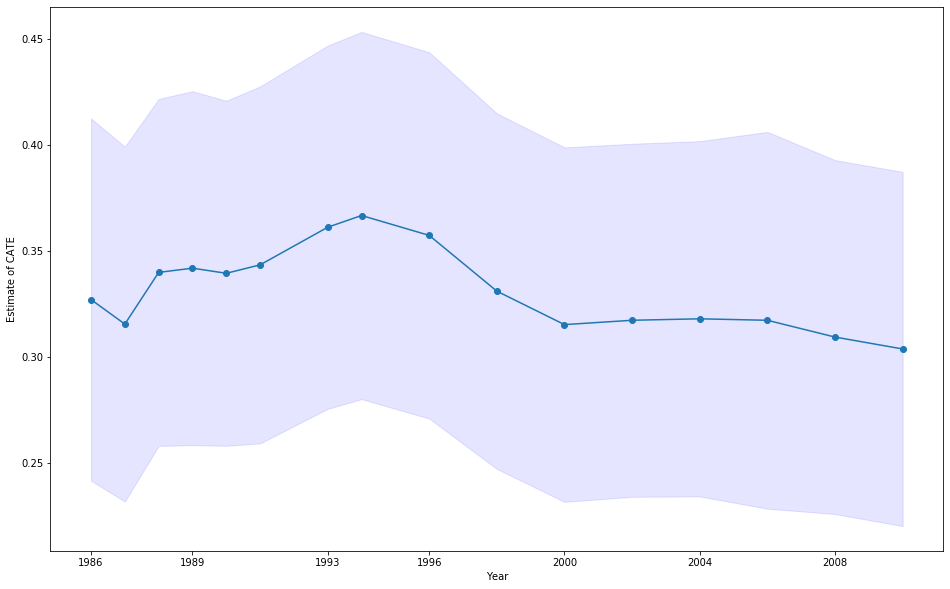

In [90]:
plt.figure(figsize=(16,10))
plt.xlabel("Year")
plt.ylabel("Estimate of CATE")
plt.plot(years, year_CATES, marker='o')
plt.fill_between(years, year_lbs, year_ubs, color='b', alpha=.1)
plt.xticks([1986, 1989, 1993, 1996, 2000, 2004, 2008], [1986, 1989, 1993, 1996, 2000, 2004, 2008])
plt.show()

## Further Analysis

In [25]:
# Shapley values show covariate/feature w greatest importance on outcome,
# helps identify subgroups
shap_values = est_general.shap_values(X_test_general)

100%|===================| 7300/7301 [75:31<00:00]       

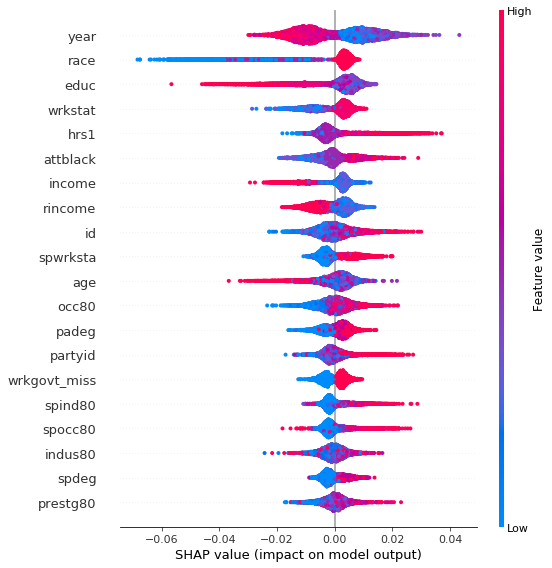

In [34]:
shap.summary_plot(shap_values['Y0']['w_1'])